# Profiling report

This notebook processes the profiling records that were generated by `$REPO_ROOT/profiler.sh`,
computes aggregate statistics
and generates plots to be used for further analysis.

Results are exported to `$REPO_ROOT/reports/nb`.

---

Log

- 23/11/2023: 
    - Updating to multi-actor profiling reports
    - Set global plot config (cfr. `sns.set_context`)
- 24/11/2023:
    - Included loading of document loader cache options (DLCOs)
- 26/11/2023
    - Histogram plots per DLCO group, for `deriveIdentityCredential`, `deriveDiplomaCredential`, `verifyPresentation01`, and `verifyPresentation02`

---


In [1]:
import os
import json
import git
import re
import numpy as np
np.random.seed(42)
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import datetime
from scipy import stats
PARENT_DIR_REPORTS = './reports/nb/'
REPORT_TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
DIR_REPORT = os.path.join(PARENT_DIR_REPORTS, REPORT_TIMESTAMP)
os.makedirs(DIR_REPORT, exist_ok=True)
DIR_REPORT

'./reports/nb/2023-11-26T22:19:04'

Plot config

In [2]:
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":8})   

---

In [3]:
def get_repo_info():    
    repo = git.Repo(path='.')
    return {
        'head': repo.head.commit.__str__(),
        'branch': repo.active_branch.__str__()
    }


def read_json(fpath: str) -> dict:
    return json.loads(open(fpath, 'r').read())

def parse_js_timestamp(jsts: int):
    """Parse timestamps created using JS/TS's `Date.now()`.
    Ref: https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Date/now
    """
    return datetime.datetime.utcfromtimestamp(jsts/1000)


## Input data

WIP: incorporating multi-actor profiling reports with varying document loader option configurations.

Note: timestamps were created using JS/TS's `Date.now()`.

> The Date.now() static method returns the number of milliseconds elapsed since the epoch, which is defined as the midnight at the beginning of January 1, 1970, UTC.

<https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Date/now>

In [4]:
def create_report_df(s_json_report_files: pd.Series) -> pd.DataFrame:
    """v20231125 - expects pd.Series containing the paths to the multi-actor report (JSON).
    These reports are expected to also include other metadata (e.g. document loader cache option configuration)
    Returns pd.DataFrame from parsed records
    """
    # Split filpaths into a parentdir & the basename of the json file
    df_files = s_json_report_files.apply(os.path.split).apply(pd.Series)
    df_files.columns = ['parent_dir','basename']
    df_files['fpath'] = s_json_report_files
    # Parse the timestamps (cfr. Date.now() in JS/TS)
    df_files['parent_dir_ts'] = df_files.parent_dir.apply(os.path.basename).astype(int).apply(parse_js_timestamp)
    df_files['report_ts'] = df_files.basename.str.replace('.json','').apply(lambda x: x.split('-')[-1]).astype(int).apply(parse_js_timestamp)

    # Read JSON files into a dataframe
    _df = df_files.iloc[:].fpath.apply(read_json).apply(pd.Series)
    # Process Document Loader Cache Options
    _df_dlco = _df['documentLoaderCacheOptions'].apply(pd.Series).stack().apply(pd.Series).unstack(1).swaplevel(axis=1).sort_index(axis=1).dropna(axis=1,how='all')
    _df_dlco.index.set_names('idx_report',inplace=True)
    # Flatten columns
    _df_dlco.columns = list(map(lambda t: '_'.join(t), _df_dlco.columns))

    # Process multi actor records
    _df_records = _df.records.apply(pd.Series).stack()
    _df_records.index.set_names(['idx_report','idx_step'],inplace=True)
    _df_records = _df_records.apply(pd.Series).drop('index',axis=1)
    
    # Combine
    _df_result = pd.concat({'report': _df_records,}, axis=1).merge(pd.concat({'dlco':_df_dlco}, axis=1), left_index=True, right_index=True)
    assert _df_result.shape[0] == _df_records.shape[0] # sanity check
    
    # Column renaming
    _df_result.rename({'tag': 'actorTag', 'name': 'stepName', },axis=1,inplace=True)
    _df_result[('report','actorStep')] = _df_result.apply(lambda r: f'{r.report.actorTag}.{r.report.stepName}',axis=1)
    _df_result.sort_index(axis=1,inplace=True)
    return _df_result
    

## Analysis

In [5]:
AGG_FUNCTIONS = ['median','mean', 'std', 'min','max','count',pd.Series.skew, pd.Series.kurt]

---

In [6]:
def get_df() -> pd.DataFrame:
    return create_report_df(pd.Series(glob('./reports/profiling/*/*.json')))
df = get_df()
df.shape

(38676, 10)

In [7]:
df.head(3)

dlco  \
                    DID_cacheResolvedDIDDocs   
idx_report idx_step                            
0          0                           False   
           1                           False   
           2                           False   

                                                                          \
                    HTTP_cacheWebResourcesResolvedFromLocalHostInstances   
idx_report idx_step                                                        
0          0                                                     False     
           1                                                     False     
           2                                                     False     

                                                              \
                    HTTP_cacheWebResourcesResolvedFromTheWeb   
idx_report idx_step                                            
0          0                                           False   
           1                                           False   
           2                                           False   

                                                  report              \
                                               actorStep    actorTag   
idx_report idx_step                                                    
0          0          university.createDiplomaCredential  university   
           1            university.signDiplomaCredential  university   
           2         government.createIdentityCredential  government   

                                                                       \
                        className delta            end          start   
idx_report idx_step                                                     
0          0         SolidVCActor     0  1700851594271  1700851594271   
           1         SolidVCActor   511  1700851594782  1700851594271   
           2         SolidVCActor     0  1700851594782  1700851594782   

                                               
                                     stepName  
idx_report idx_step                            
0          0          createDiplomaCredential  
           1            signDiplomaCredential  
           2         createIdentityCredential

The reports will be considered in groups, divided by the following group columns:
    
- `actorTag`: the name/tag of an actor within the context of the use case (e.g. alice)
- `className`: the classname of an actor's implementation (e.g. `SolidVCACtor`)
- `actorStep` the profiled step/action taken by the actor (e.g. `verifyPresentation`)

In [8]:
def equalize_groupsizes(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:
    """ Creates equally sized groups (based on the smallest group size).
    """
    grpr = df.groupby(group_columns)
    n_smallest_group = grpr.size().min()
    idx_to_drop = []
    for i,g_idx in grpr.groups.items():
        ni_idx_to_drop = g_idx.size - n_smallest_group
        np.random.seed(42)
        idx_to_drop.append(np.random.choice(g_idx,size=ni_idx_to_drop))

    idx_to_drop = np.concatenate(idx_to_drop)
    return df.drop(index=idx_to_drop)

In [9]:
def jsonpath2multi_index_tuple(path: str):
    """
    Example: 
    jsonpath2multi_index_tuple('report.actorTag')
    ('report', 'actorTag')
    """
    return tuple(path.split('.'))

In [10]:
jsonpath2multi_index_tuple('report.actorTag')

('report', 'actorTag')

In [11]:
# Add phases
phase_steps = {
    'pre-evaluation': [
        'university.createDiplomaCredential',
        'university.signDiplomaCredential',
        'government.createIdentityCredential',
        'government.signIdentityCredential',
    ],
     'phase-1': [
        'alice.deriveDiplomaCredential',
        'alice.createPresentation01',
        'alice.signPresentation01',
        'recruiter.verifyPresentation01'
    ],
    'phase-2': [
        'alice.deriveIdentityCredential',
        'alice.createPresentation02',
        'alice.signPresentation02',
        'recruiter.verifyPresentation02'
    ],
}
df_phase_steps = pd.Series(phase_steps)\
    .apply(pd.Series)\
    .stack()\
    .to_frame('actorStep')\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename({'level_0': 'phase'}, axis=1)
# Create multi-index (for later)
df_phase_steps = pd.concat({'report':df_phase_steps},axis=1)
# sanity check: make sure that actorSteps exactly match
x = set(df.report.actorStep.value_counts(dropna=False).index)
y = set(df_phase_steps.report.actorStep.value_counts().index)
assert len(x-y) == 0
df_phase_steps.head(3)

# merge df with phases back to df_tl
df_tl = df.reset_index().merge(df_phase_steps, on=[('report','actorStep')])

# Log(1+delta) transform to get a "more Gaussian" distribution
df_tl[('report','delta_log1p')] = df_tl[('report','delta')].apply(np.log1p)

# Equalize group sizes
GROUP_COLUMNS = list(map(jsonpath2multi_index_tuple, ['report.actorTag','report.className','report.actorStep']))
df_tl = equalize_groupsizes(df_tl, GROUP_COLUMNS)

df_tl

idx_report idx_step                     dlco  \
                          DID_cacheResolvedDIDDocs   
0              0        0                    False   
1              1        0                    False   
2              2        0                    False   
3              3        0                    False   
4              4        0                    False   
...          ...      ...                      ...   
38671       3218       11                     True   
38672       3219       11                     True   
38673       3220       11                     True   
38674       3221       11                     True   
38675       3222       11                     True   

                                                            \
      HTTP_cacheWebResourcesResolvedFromLocalHostInstances   
0                                                  False     
1                                                  False     
2                                                  False     
3                                                  False     
4                                                  False     
...                                                  ...     
38671                                              False     
38672                                              False     
38673                                              False     
38674                                              False     
38675                                              False     

                                                \
      HTTP_cacheWebResourcesResolvedFromTheWeb   
0                                        False   
1                                        False   
2                                        False   
3                                        False   
4                                        False   
...                                        ...   
38671                                    False   
38672                                    False   
38673                                    False   
38674                                    False   
38675                                    False   

                                   report                                  \
                                actorStep    actorTag     className delta   
0      university.createDiplomaCredential  university  SolidVCActor     0   
1      university.createDiplomaCredential  university  SolidVCActor     0   
2      university.createDiplomaCredential  university  SolidVCActor     0   
3      university.createDiplomaCredential  university    DidVCActor     0   
4      university.createDiplomaCredential  university  SolidVCActor     0   
...                                   ...         ...           ...   ...   
38671      recruiter.verifyPresentation02   recruiter  SolidVCActor   349   
38672      recruiter.verifyPresentation02   recruiter    DidVCActor   794   
38673      recruiter.verifyPresentation02   recruiter    DidVCActor   760   
38674      recruiter.verifyPresentation02   recruiter  SolidVCActor   389   
38675      recruiter.verifyPresentation02   recruiter  SolidVCActor   415   

                                                                              \
                 end          start                 stepName           phase   
0      1700851594271  1700851594271  createDiplomaCredential  pre-evaluation   
1      1700854579769  1700854579769  createDiplomaCredential  pre-evaluation   
2      1700854859296  1700854859296  createDiplomaCredential  pre-evaluation   
3      1700858484033  1700858484033  createDiplomaCredential  pre-evaluation   
4      1700858507094  1700858507094  createDiplomaCredential  pre-evaluation   
...              ...            ...                      ...             ...   
38671  1700861554094  1700861553745     verifyPresentation02         phase-2   
38672  1700865359652  1700865358858     verifyPresentation02         phase-2   
38673  1700865757610  1700865756850     ver

#### Nr. reports

In [12]:
assert df_tl.groupby(['idx_report',]).count().stack([0,1]).unique().__len__() == 1 # sanity check: equal nr of samples per group
# nr reports
N = df_tl.idx_report.unique().__len__()
N

/var/folders/tf/j9ycytm53pzbs56ftdt8rp_w0000gn/T/ipykernel_5415/89981526.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  assert df_tl.groupby(['idx_report',]).count().stack([0,1]).unique().__len__() == 1 # sanity check: equal nr of samples per group


3222

#### Sample groups

In [13]:
# grouper object for the reports
grpr = df_tl.groupby(GROUP_COLUMNS)
grpr

In [14]:
GROUPS = list(grpr.groups.keys())

##### Group sizes

In [52]:
grpr.size()

(report, actorTag)  (report, className)  (report, actorStep)                
alice               DidVCActor           alice.createPresentation01             1611
                                         alice.createPresentation02             1611
                                         alice.deriveDiplomaCredential          1611
                                         alice.deriveIdentityCredential         1611
                                         alice.signPresentation01               1611
                                         alice.signPresentation02               1611
                    SolidVCActor         alice.createPresentation01             1611
                                         alice.createPresentation02             1611
                                         alice.deriveDiplomaCredential          1611
                                         alice.deriveIdentityCredential         1611
                                         alice.signPresentation01        

In [16]:
# sanity check: assert that the same number of samples, for each group!
if not grpr.size().value_counts().shape[0] != 0:
    raise Warning('Groups do not have an equal number of samples!')

df_tl.to_csv(os.path.join(DIR_REPORT, 'df_task-level.csv'))

In [17]:
# Make sure that every report has the same number of actor steps
assert (df_tl.reset_index().groupby('idx_report').count() == 12).all().all()

/var/folders/tf/j9ycytm53pzbs56ftdt8rp_w0000gn/T/ipykernel_5415/1571744100.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  assert (df_tl.reset_index().groupby('idx_report').count() == 12).all().all()


In [18]:
# df_stepname_order is used to specify the order of plots
df_stepname_order = df_tl.set_index(['idx_report','idx_step']).report.reset_index().reset_index()[['idx_step','stepName','actorTag','actorStep','phase']].drop_duplicates()
df_stepname_order

,idx_step,stepName,actorTag,actorStep,phase
0,0,createDiplomaCredential,university,university.createDiplomaCredential,pre-evaluation
3222,1,signDiplomaCredential,university,university.signDiplomaCredential,pre-evaluation
6444,2,createIdentityCredential,government,government.createIdentityCredential,pre-evaluation
9666,3,signIdentityCredential,government,government.signIdentityCredential,pre-evaluation
12888,4,deriveDiplomaCredential,alice,alice.deriveDiplomaCredential,phase-1
16110,5,createPresentation01,alice,alice.createPresentation01,phase-1
19332,6,signPresentation01,alice,alice.signPresentation01,phase-1
22554,7,verifyPresentation01,recruiter,recruiter.verifyPresentation01,phase-1
25776,8,deriveIdentityCredential,alice,alice.deriveIdentityCredential,phase-2
28998,9,createPresentation02,alice,alice.createPresentation02,phase-2


In [19]:
VAR_X = 'delta_log1p'

In [20]:
kwargs_violinplot = dict(
    x=VAR_X,
    y='actorStep',
    hue='className'
)

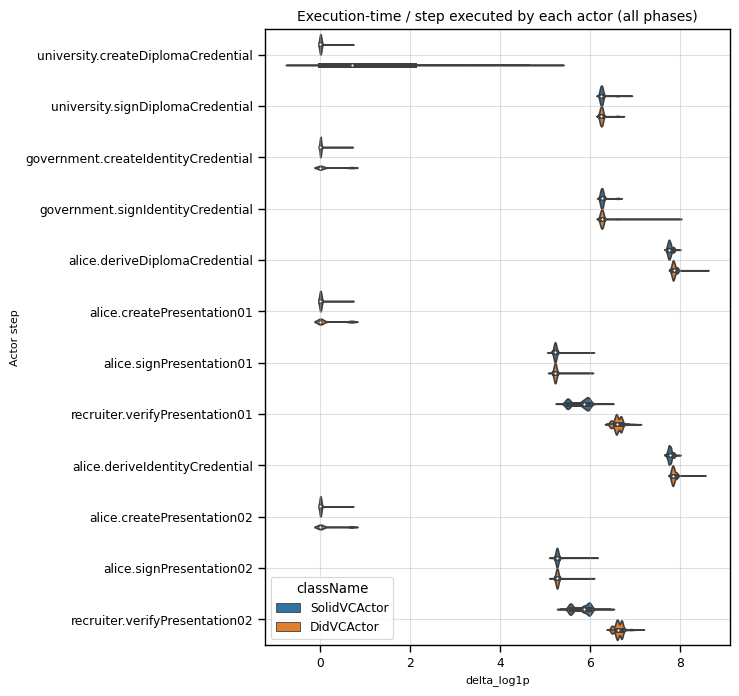

In [21]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = f'Execution-time / step executed by each actor (all phases)'
ax = sns.violinplot(df_tl.report,
                    **kwargs_violinplot,
                    order=df_stepname_order['actorStep'],
                    tight_layout=True,
                    ax=ax)
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel(f'{kwargs_violinplot["x"]}')
ax.grid(alpha=.4)

plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-all-phases.png'),pad_inches=.5)
plt.show()

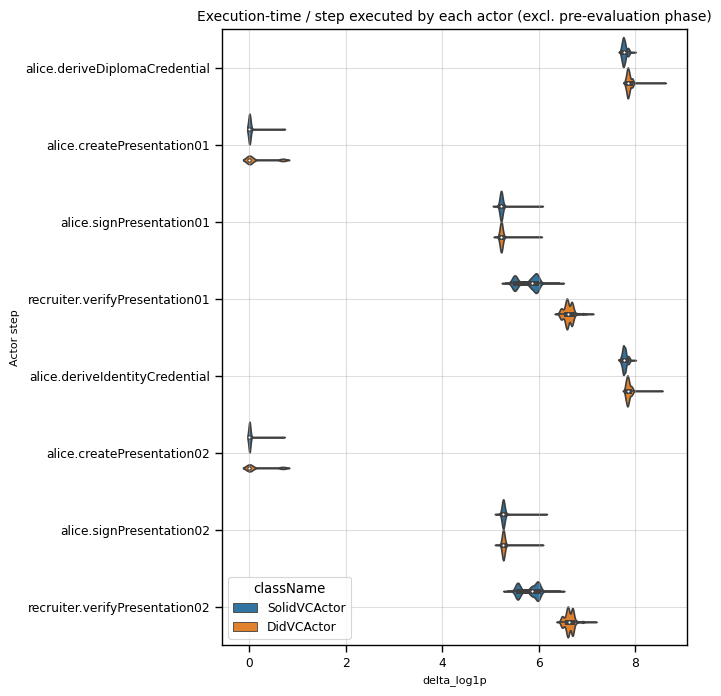

In [22]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = f'Execution-time / step executed by each actor (excl. pre-evaluation phase)'
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']
order_data = df_stepname_order[df_stepname_order.phase != 'pre-evaluation']['actorStep']
ax = sns.violinplot(snsdata,
                    **kwargs_violinplot,
                    order=order_data,
                    tight_layout=True,
                    ax=ax,
                   )
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel(VAR_X)
ax.grid(alpha=.4)
plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-excl-pre-evaluation-phase.png'),pad_inches=.5)
plt.show()

In [23]:
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']

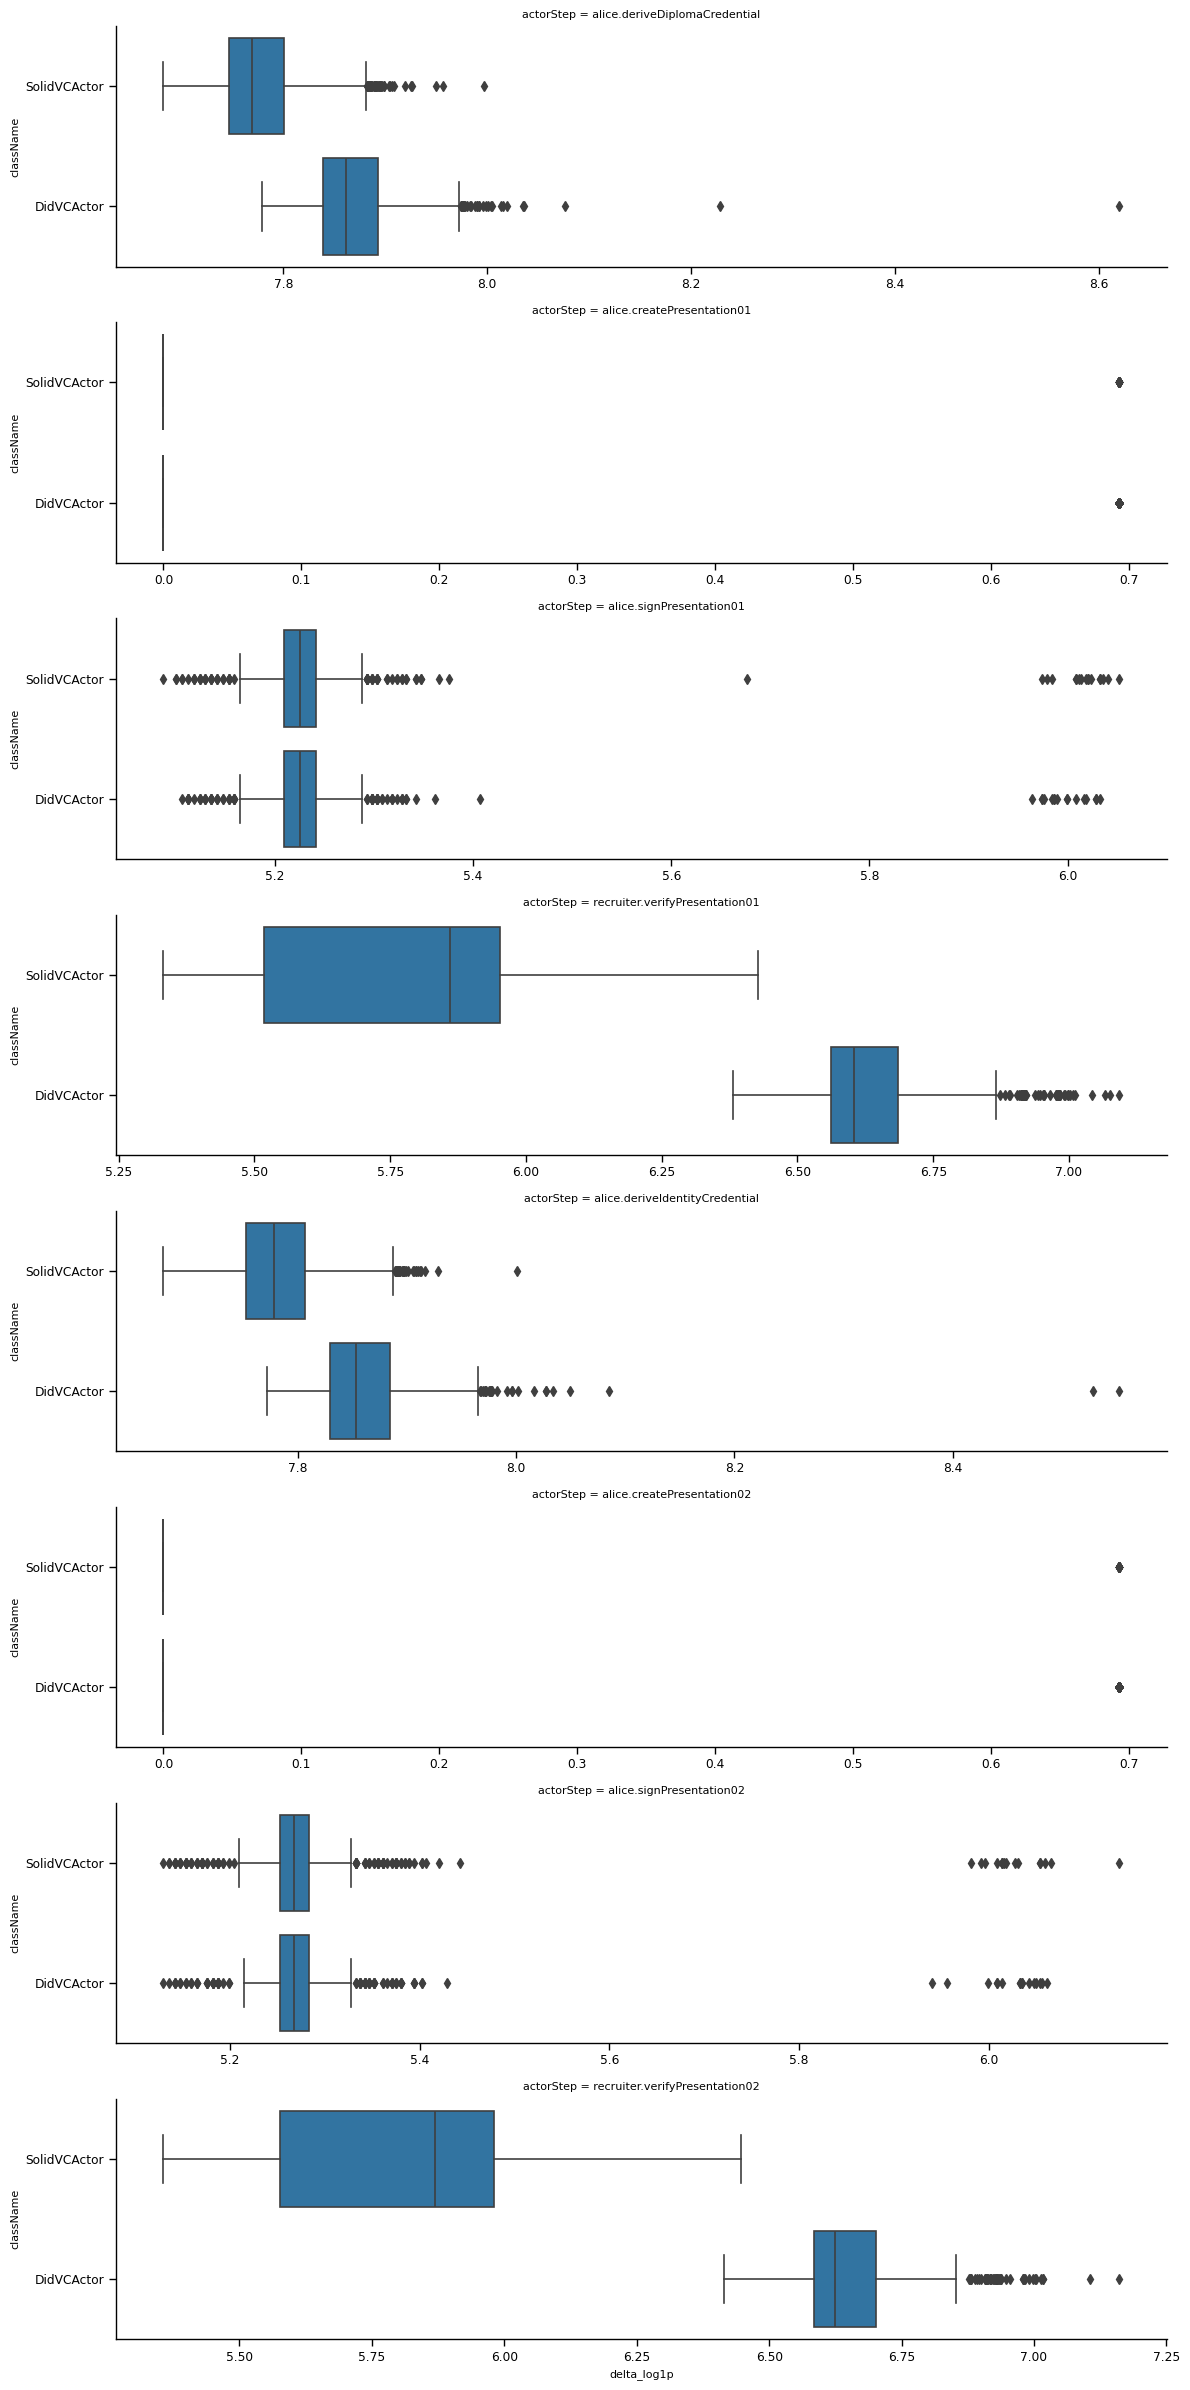

In [24]:
g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.boxplot, x=VAR_X, y='className')
plt.show()

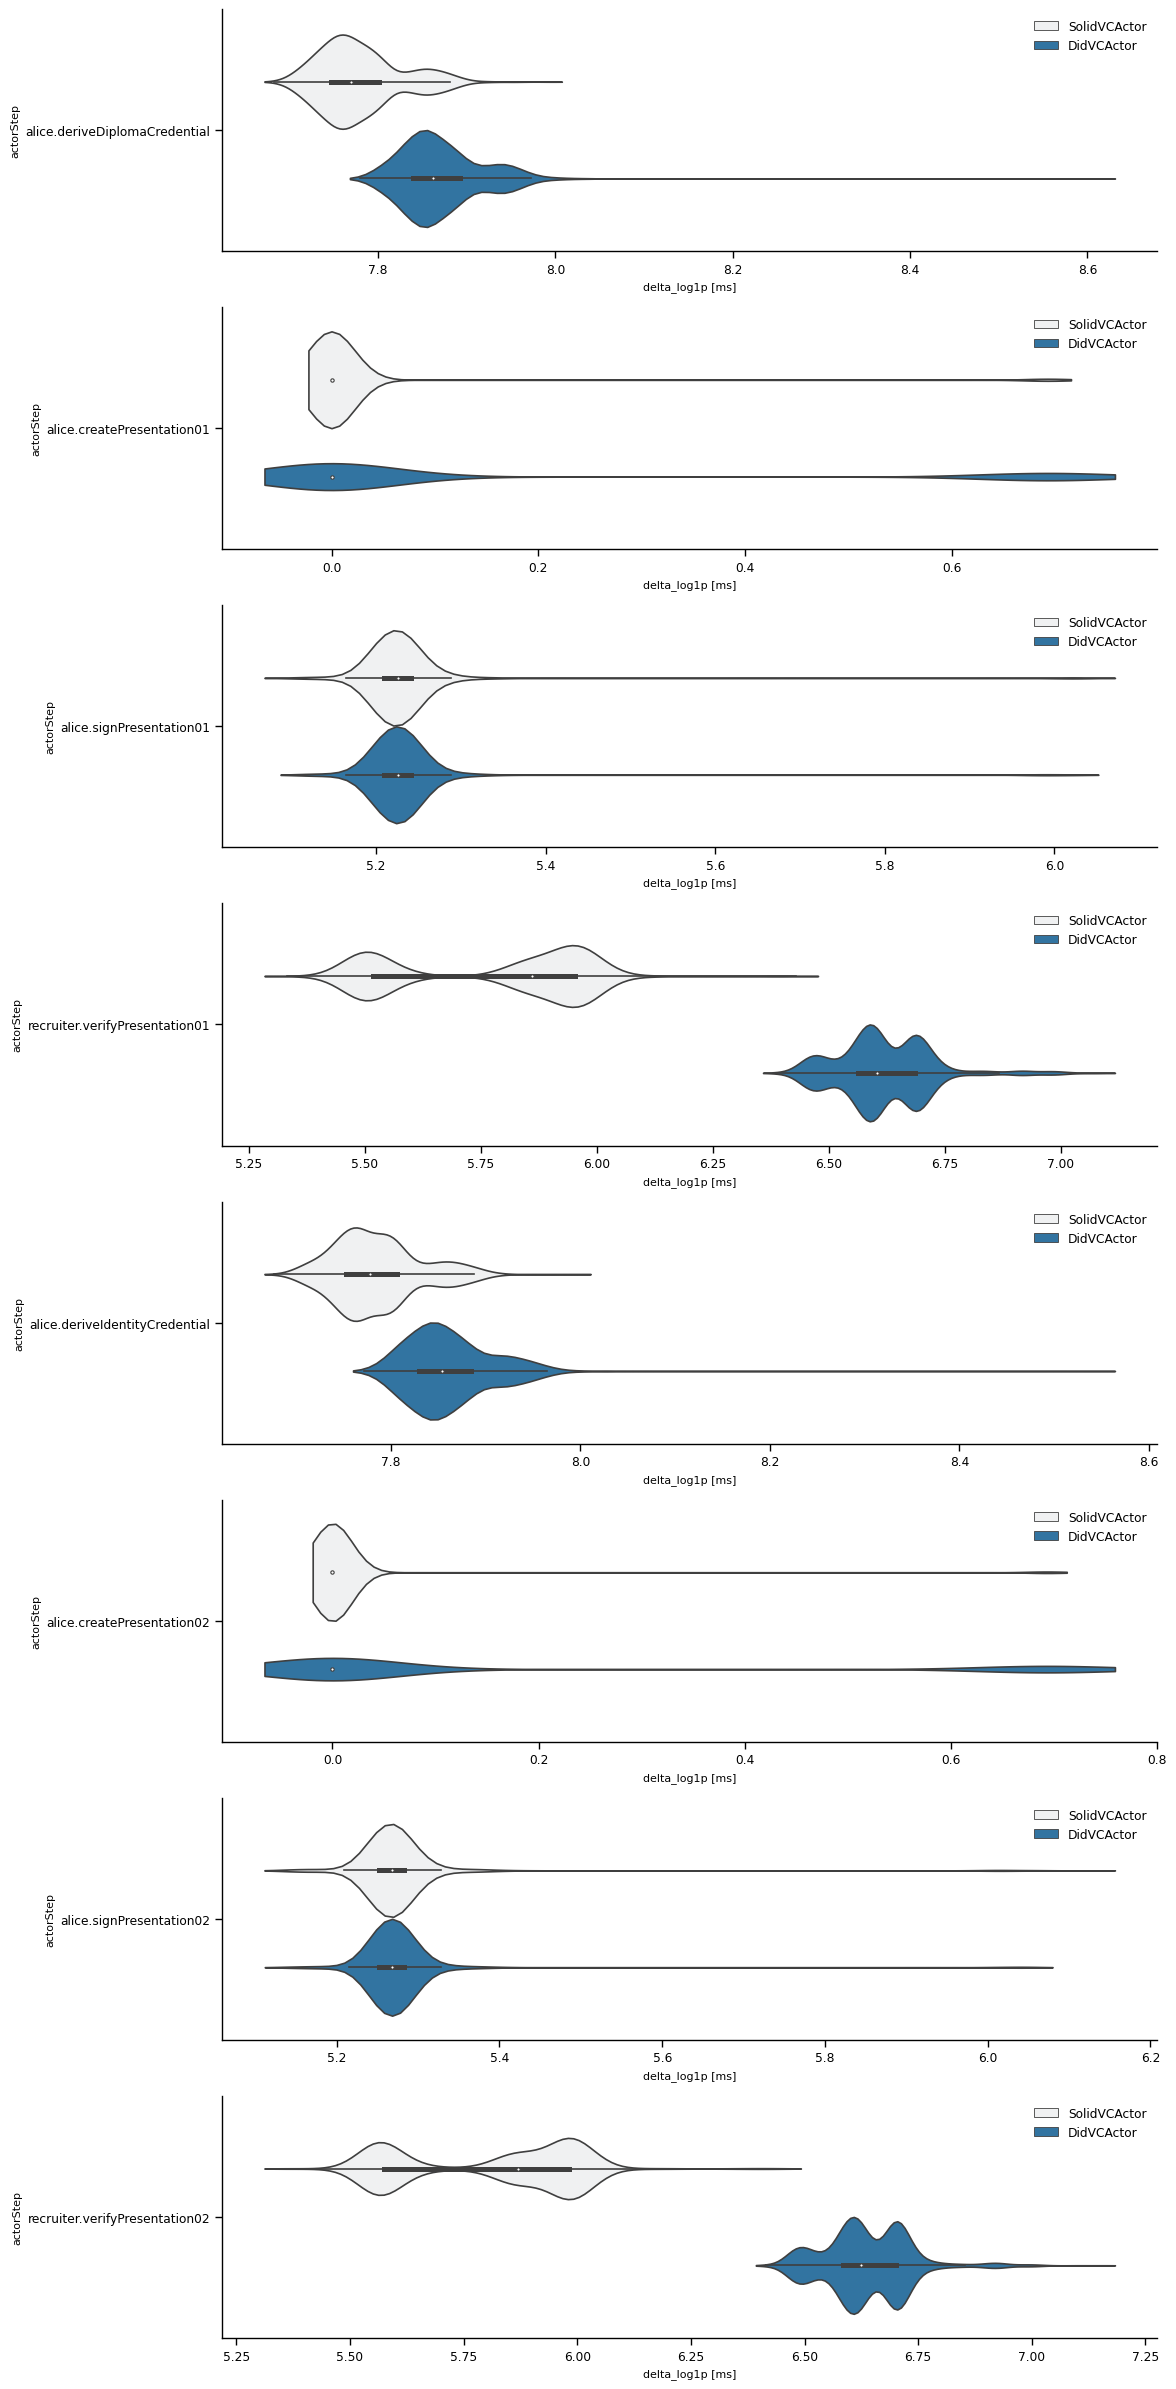

In [25]:
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']
kwargs_plot = dict(
    x=VAR_X,
    y='actorTag',
    hue='className',
    orient='h',
    showfliers=False,
)

g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.violinplot,
                **kwargs_violinplot,
                #inner='point',
                #inner='quart',
#                split='quart',
                cut=1,
                inner_kws=dict(box_width=15, whis_width=2, color=".8")

                
               )
# Create main legend
g.add_legend()
for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    ax.set_title('')
    # Add a copy of the main legend to each subplot
    ax.legend(handles=g.legend.legend_handles,frameon=False)

# Hide main legend
g.legend.set_visible(False)
g.tight_layout()
plt.show()

Compute & export aggregate statistics

In [26]:
# name refers to the function/step name
df_tl_agg = df_tl.report.groupby(['actorTag','className','stepName'])[['delta']].agg(AGG_FUNCTIONS)
df_tl_agg.to_csv(os.path.join(DIR_REPORT, 'df_agg_task-level.csv'))
df_tl_agg.shape

(24, 8)

In [27]:
df_tl_agg.unstack('className').swaplevel(1,2,axis=1).sort_index(axis=1)

delta                                 \
className                           DidVCActor                                  
                                         count        kurt   max         mean   
actorTag   stepName                                                             
alice      createPresentation01           1611   -0.054369     1     0.214153   
           createPresentation02           1611   -0.234234     1     0.223464   
           deriveDiplomaCredential        1611  112.746064  5539  2621.913718   
           deriveIdentityCredential       1611  106.468409  5179  2598.563004   
           signPresentation01             1611   86.390517   416   187.129112   
           signPresentation02             1611   85.662820   428   195.468653   
government createIdentityCredential       1611   -0.140422     1     0.218498   
           signIdentityCredential         1611  655.338228  2975   534.679081   
recruiter  verifyPresentation01           1611    4.297050  1202   752.358163   
           verifyPresentation02           1611    4.348202  1287   765.410304   
university createDiplomaCredential        1611    0.449659   103    17.406580   
           signDiplomaCredential          1611   16.829831   834   528.199255   

                                                                          \
className                                                                  
                                     median   min       skew         std   
actorTag   stepName                                                        
alice      createPresentation01         0.0     0   1.394883    0.410361   
           createPresentation02         0.0     0   1.328931    0.416696   
           deriveDiplomaCredential   2595.0  2390   6.187441  141.827064   
           deriveIdentityCredential  2574.0  2371   6.698310  146.954758   
           signPresentation01         185.0   164   9.129710   22.100408   
           signPresentation02         193.0   168   9.046381   22.453999   
government createIdentityCredential     0.0     0   1.363728    0.413355   
           signIdentityCredential     526.0   486  21.313932   76.204086   
recruiter  verifyPresentation01       737.0   590   1.447211   82.008386   
           verifyPresentation02       752.0   610   1.274749   77.143046   
university createDiplomaCredential      1.0     0   1.547411   32.572696   
           signDiplomaCredential      520.0   480   4.084051   46.043842   

                                                                    \
className                           SolidVCActor                     
                                           count        kurt   max   
actorTag   stepName                                                  
alice      createPresentation01             1611   43.979194     1   
           createPresentation02             1611   62.337150     1   
           deriveDiplomaCredential          1611    0.686401  2970   
           deriveIdentityCredential         1611    0.457904  2981   
           signPresentation01               1611   84.703914   424   
           signPresentation02               1611   84.530620   462   
government createIdentityCredential         1611  110.426345     1   
           signIdentityCredential           1611   17.021227   793   
recruiter  verifyPresentation01             1611   -0.296528   618   
           verifyPresentation02             1611   -0.177734   630   
university createDiplomaCredential          1611   50.731093     1   
           signDiplomaCredential            1611   22.811778   994   

                                                                           \
className                                                                   
                                            mean  median   min       skew   
actorTag   stepName                                                         
alice      createPresentation01         0.020484     0.0     0   6.776769   
           createPres

Compact overview of the each group's mean & median aggregates for the `delta`-variable.

In [28]:
df_tl_agg.unstack('className').swaplevel(0,1,axis=1).sort_index(axis=1).filter(regex='median|mean').round(2)

mean                  median  \
                                         delta                   delta   
className                           DidVCActor SolidVCActor DidVCActor   
actorTag   stepName                                                      
alice      createPresentation01           0.21         0.02        0.0   
           createPresentation02           0.22         0.01        0.0   
           deriveDiplomaCredential     2621.91      2390.34     2595.0   
           deriveIdentityCredential    2598.56      2404.08     2574.0   
           signPresentation01           187.13       187.08      185.0   
           signPresentation02           195.47       195.20      193.0   
government createIdentityCredential       0.22         0.01        0.0   
           signIdentityCredential       534.68       533.06      526.0   
recruiter  verifyPresentation01         752.36       327.85      737.0   
           verifyPresentation02         765.41       338.21      752.0   
university createDiplomaCredential       17.41         0.02        1.0   
           signDiplomaCredential        528.20       529.33      520.0   

                                                  
                                                  
className                           SolidVCActor  
actorTag   stepName                               
alice      createPresentation01              0.0  
           createPresentation02              0.0  
           deriveDiplomaCredential        2366.0  
           deriveIdentityCredential       2387.0  
           signPresentation01              185.0  
           signPresentation02              193.0  
government createIdentityCredential          0.0  
           signIdentityCredential          525.0  
recruiter  verifyPresentation01            350.0  
           verifyPresentation02            353.0  
university createDiplomaCredential           0.0  
           signDiplomaCredential           521.0

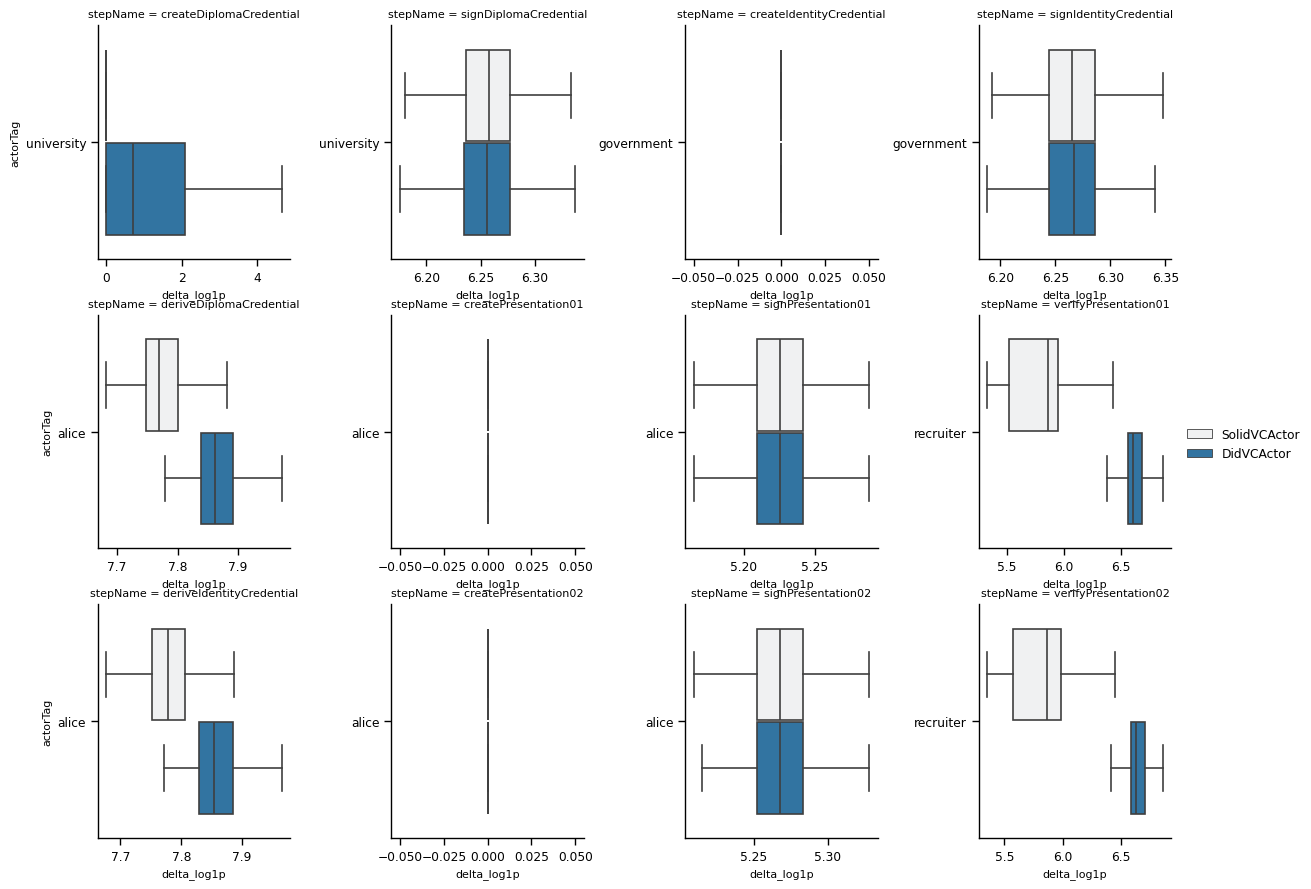

In [29]:
kwargs_fg = dict(col = 'stepName',  col_wrap=4, sharey=False,sharex=False,aspect=1)
kwargs_plot = dict(
    x=VAR_X,
    y='actorTag',
    hue='className',
    orient='h',
    showfliers=False,
)
g = sns.FacetGrid(**kwargs_fg, data=df_tl.report)
g.map_dataframe(sns.boxplot, **kwargs_plot)

for ax in g.axes.ravel():
    ax.set_xlabel('{}'.format(kwargs_plot['x']))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    pass
g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'boxplot-actor-on-delta-per-step.png'),pad_inches=.5)
plt.show()

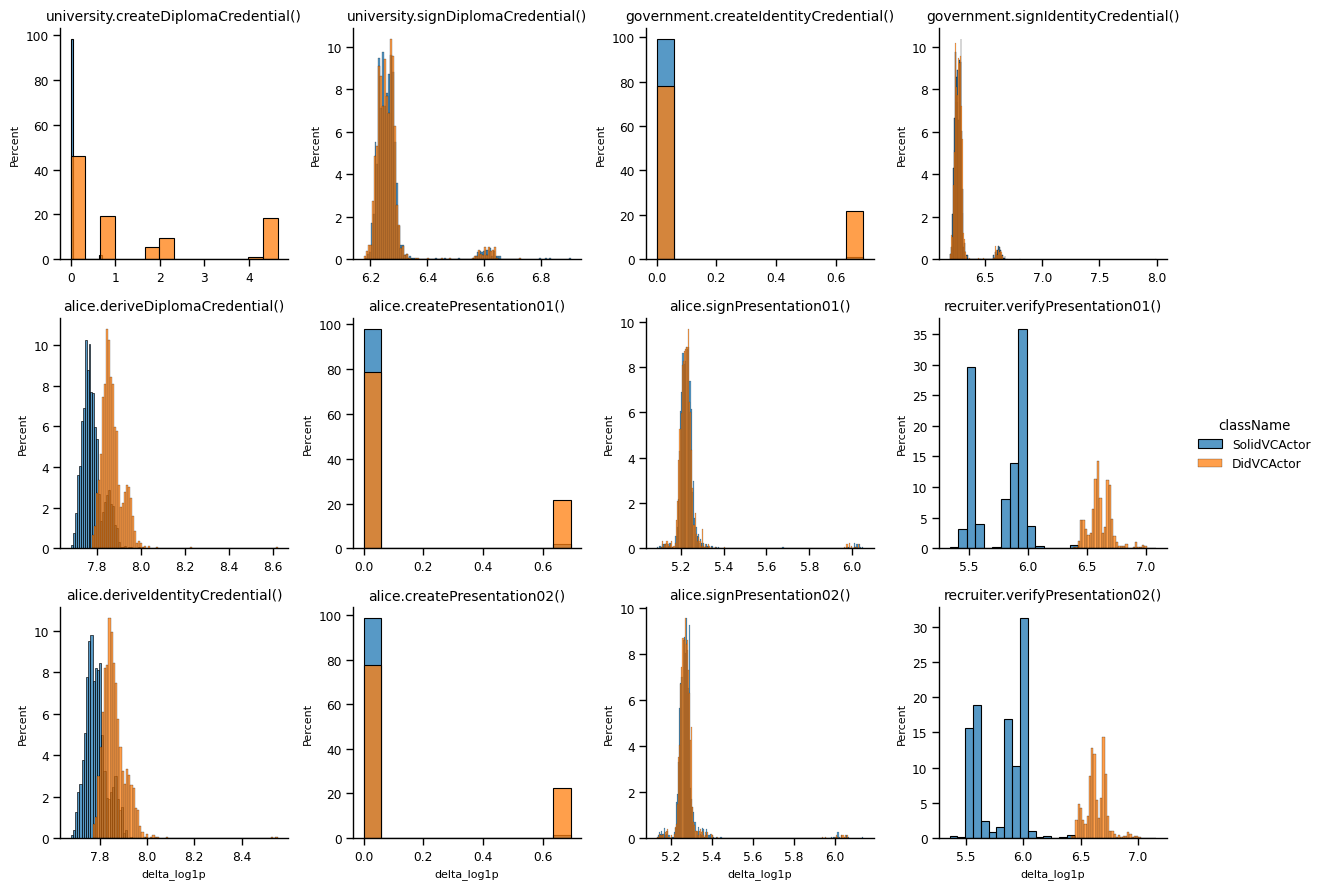

In [30]:
kwargs_fg = dict(col = 'stepName',
                 hue='className',
                 col_wrap=4,
                 sharey=False,
                 sharex=False,
                 legend_out=True,
                 col_order = df_stepname_order['stepName']
)
kwargs_plot = dict(
    x=VAR_X,
    stat='percent',
    element='bars',
)

g = sns.FacetGrid(**kwargs_fg, data=df_tl.report)
g = g.map_dataframe(sns.histplot,
                    x=VAR_X,
                    stat='percent',
                    element='bars')
for ax in g.axes.ravel():
    pass

for i, r in df_stepname_order.iterrows():
    ax_i = g.axes_dict[r.stepName]
    ax_i.set_title(f'{r.actorTag}.{r.stepName}()')


g.add_legend()
g.tight_layout()


plt.savefig(os.path.join(DIR_REPORT,'barplot-actor-on-percentage-delta-per-step.png'),bbox_inches='tight')
plt.show()

In [31]:
df_tl.report.groupby(['phase','actorTag','className','actorStep'])[['delta']].agg(['mean']).unstack('className')

delta  \
                                                                      mean   
className                                                       DidVCActor   
phase          actorTag   actorStep                                          
phase-1        alice      alice.createPresentation01              0.214153   
                          alice.deriveDiplomaCredential        2621.913718   
                          alice.signPresentation01              187.129112   
               recruiter  recruiter.verifyPresentation01        752.358163   
phase-2        alice      alice.createPresentation02              0.223464   
                          alice.deriveIdentityCredential       2598.563004   
                          alice.signPresentation02              195.468653   
               recruiter  recruiter.verifyPresentation02        765.410304   
pre-evaluation government government.createIdentityCredential     0.218498   
                          government.signIdentityCredential     534.679081   
               university university.createDiplomaCredential     17.406580   
                          university.signDiplomaCredential      528.199255   

                                                                            
                                                                            
className                                                     SolidVCActor  
phase          actorTag   actorStep                                         
phase-1        alice      alice.createPresentation01              0.020484  
                          alice.deriveDiplomaCredential        2390.338920  
                          alice.signPresentation01              187.084420  
               recruiter  recruiter.verifyPresentation01        327.854128  
phase-2        alice      alice.createPresentation02              0.014898  
                          alice.deriveIdentityCredential       2404.081937  
                          alice.signPresentation02              195.196772  
               recruiter  recruiter.verifyPresentation02        338.214773  
pre-evaluation government government.createIdentityCredential     0.008690  
                          government.signIdentityCredential     533.059590  
               university university.createDiplomaCredential      0.018001  
                          university.signDiplomaCredential      529.326505

In [32]:
# TODO: REFACTOR
get_repo_info()
json.dump(get_repo_info(), open(os.path.join(DIR_REPORT,'repo-info.json'), 'w'))

## Statistics

### Significance testing

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [33]:
p_thresh = .05

In [34]:
steps = df_tl.report.stepName.unique()
print(steps)

['createDiplomaCredential' 'signDiplomaCredential'
 'createIdentityCredential' 'signIdentityCredential'
 'deriveDiplomaCredential' 'createPresentation01' 'signPresentation01'
 'verifyPresentation01' 'deriveIdentityCredential' 'createPresentation02'
 'signPresentation02' 'verifyPresentation02']


In [35]:
grpr_className = df_tl.report.groupby('className')
assert grpr_className.ngroups == 2 # sanity check
A,B = grpr_className

In [36]:
_var = VAR_X
ttr_ind_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

print(f'''
    Group A: {k_a}
    Group B: {k_b}
    Tested variable: {_var}
''')
for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var].values.tolist()
        b = df_b[df_b.stepName == step_name][_var].values.tolist()
        if np.shape(a) != np.shape(b):
            print(np.shape(a), np.shape(b))
        assert np.shape(a) == np.shape(b)

        ttr_ind_per_step[step_name]=stats.ttest_ind(a,b)
        
df_test_results = pd.Series(ttr_ind_per_step).apply(lambda t: t._asdict()).apply(pd.Series)
df_test_results.rename({'statistic': 'tvalue'}, axis=1,inplace=True)
# Add flag to indicate whether to accept/reject H0
df_test_results['REJECT_H0'] = df_test_results.pvalue < p_thresh
df_test_results['Conclusion'] = df_test_results.REJECT_H0.apply(lambda reject_H0: 
                                                                f'Significant difference (p<{p_thresh}) in "{_var}" between {k_a} and {k_b}' if reject_H0
                                                                else f'No significant difference in "{_var}" between {k_a} and {k_b}' 
                                                               )
df_test_results.to_csv(os.path.join(DIR_REPORT, 'df_significance-tests.csv'))
df_test_results


    Group A: DidVCActor
    Group B: SolidVCActor
    Tested variable: delta_log1p



,tvalue,pvalue,df,_alternative,_standard_error,_estimate,REJECT_H0,Conclusion
createDiplomaCredential,30.673773,1.698565e-181,3220.0,0.0,0.042083,1.290855,True,"Significant difference (p<0.05) in ""delta_log1..."
signDiplomaCredential,-0.678969,4.972063e-01,3220.0,0.0,0.002697,-0.001831,False,"No significant difference in ""delta_log1p"" bet..."
createIdentityCredential,19.877313,5.016194e-83,3220.0,0.0,0.007316,0.145428,True,"Significant difference (p<0.05) in ""delta_log1..."
signIdentityCredential,0.450521,6.523651e-01,3220.0,0.0,0.002820,0.001270,False,"No significant difference in ""delta_log1p"" bet..."
deriveDiplomaCredential,54.928522,0.000000e+00,3220.0,0.0,0.001679,0.092244,True,"Significant difference (p<0.05) in ""delta_log1..."
createPresentation01,17.905332,2.005435e-68,3220.0,0.0,0.007497,0.134241,True,"Significant difference (p<0.05) in ""delta_log1..."
signPresentation01,0.184595,8.535583e-01,3220.0,0.0,0.002914,0.000538,False,"No significant difference in ""delta_log1p"" bet..."
verifyPresentation01,143.771148,0.000000e+00,3220.0,0.0,0.005880,0.845408,True,"Significant difference (p<0.05) in ""delta_log1..."
deriveIdentityCredential,45.771198,0.000000e+00,3220.0,0.0,0.001692,0.077455,True,"Significant difference (p<0.05) in ""delta_log1..."
createPresentation02,19.290481,1.485063e-78,3220.0,0.0,0.007494,0.144567,True,"Significant difference (p<0.05) in ""delta_log1..."


In [37]:
steps_with_sig_diff = df_test_results[df_test_results.REJECT_H0].index
print(list(steps_with_sig_diff))

['createDiplomaCredential', 'createIdentityCredential', 'deriveDiplomaCredential', 'createPresentation01', 'verifyPresentation01', 'deriveIdentityCredential', 'createPresentation02', 'verifyPresentation02']


In [38]:
df_tl_sig_diff = df_tl.report[df_tl.report.stepName.apply(lambda n: n in steps_with_sig_diff)]
df_tl_sig_diff.shape

(25776, 9)

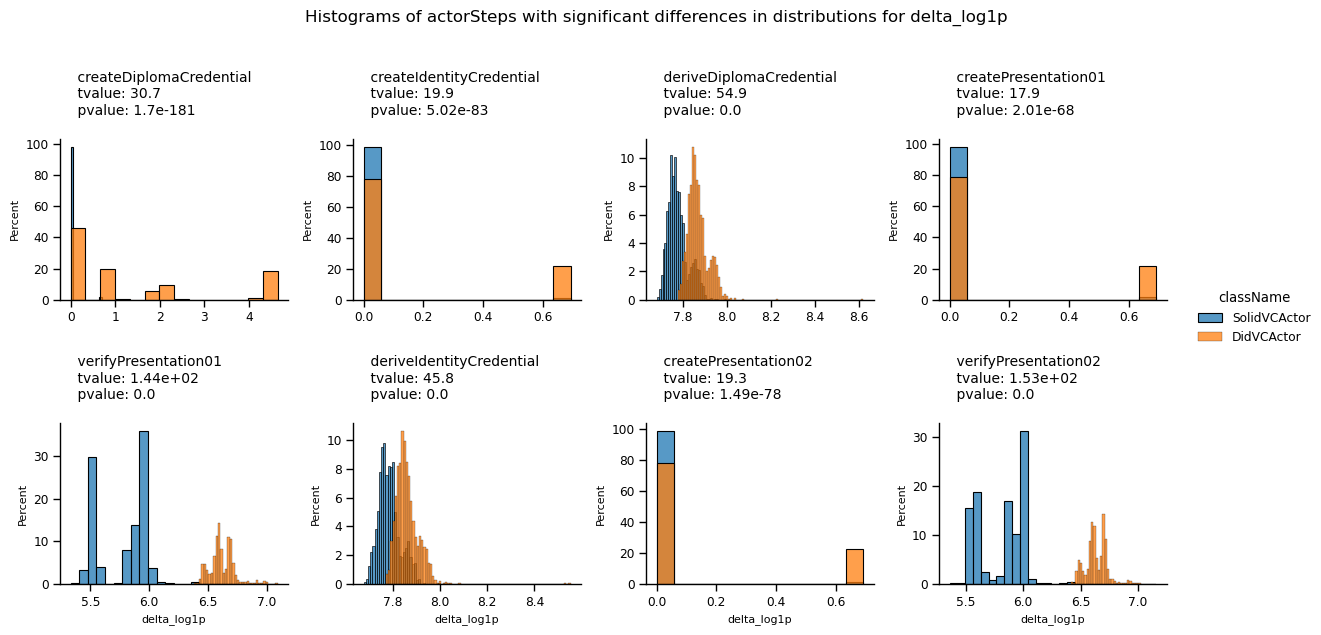

In [39]:
g = sns.FacetGrid(df_tl_sig_diff,col='stepName',legend_out=True, hue='className',sharex=False, sharey=False, col_wrap=4)
g = g.map_dataframe(sns.histplot,
                    x=VAR_X,
                    stat='percent',
                    element='bars')
g.add_legend()

for c in g.col_names:
    s = df_test_results.loc[c]

    g.axes_dict[c].set_title('',loc='center')
    txt_stats = f'''
    {c}
    tvalue: {s["tvalue"]:.3}
    pvalue: {s["pvalue"]:.3}
    '''
    g.axes_dict[c].set_title(txt_stats,loc='left')
    
g.tight_layout()
suptitle = plt.suptitle(f'Histograms of actorSteps with significant differences in distributions for {VAR_X}',y=1.05)
plt.show()

### Effect size

#### Cohen's d

$$
d = \frac{\bar x_1 - \bar x_2}{s}
$$

|Effect size|	d|
|-----------|----|
|Very small	|0.01|
|Small		|0.20|
|Medium		|0.50|
|Large		|0.80|
|Very large	|1.20|
|Huge		|2.00|


> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [40]:
from numpy import var, mean, sqrt

def cohend(d1: pd.Series, d2: pd.Series) -> float:

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)

    # return the effect size
    return (u1 - u2) / s

> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [41]:
_var = 'delta_log1p'
effect_size_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var]
        b = df_b[df_b.stepName == step_name][_var]
        effect_size_per_step[step_name] = cohend(a,b)
        

colname_effect_size =f'cohend_{k_a}_{k_b}__{_var}'
s_effect_sizes = pd.Series(effect_size_per_step, name=colname_effect_size)

df_effect_sizes = s_effect_sizes.to_frame()
def cohend_effect_class(d: float) -> str:
    d = np.abs(d)
    if d >= 2.0:
        return 'HUGE'
    if d >= 1.2:
        return 'VERY_LARGE'
    if d >= 0.8:
        return 'LARGE'
    if d >= 0.5:
        return 'MEDIUM'
    if d >= 0.2:
        return 'SMALL'
    if d > 0.01:
        return 'VERY_SMALL'
    return 'NIHIL'

df_effect_sizes['effect_class'] = s_effect_sizes.apply(cohend_effect_class)
def create_explanation(r) -> str:
    es = r[colname_effect_size]
    pos = es > 0
    ec = r.effect_class
    
    return f'The mean of {k_a} is {"greater" if pos else "smaller"} than the mean of {k_b}, with effect size: {es} (which can be classified as {ec}).'
df_effect_sizes['explanation'] = df_effect_sizes.apply(create_explanation, axis=1)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
df_effect_sizes.to_csv(os.path.join(DIR_REPORT, 'df_effect_sizes.csv'))
df_effect_sizes

,cohend_DidVCActor_SolidVCActor__delta_log1p,effect_class,explanation
createDiplomaCredential,1.080773,LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.0807728471248015 (which can be classified as LARGE)."
signDiplomaCredential,-0.023923,VERY_SMALL,"The mean of DidVCActor is smaller than the mean of SolidVCActor, with effect size: -0.023923086355168335 (which can be classified as VERY_SMALL)."
createIdentityCredential,0.700366,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.7003657426658256 (which can be classified as MEDIUM)."
signIdentityCredential,0.015874,VERY_SMALL,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.01587384994798249 (which can be classified as VERY_SMALL)."
deriveDiplomaCredential,1.935375,VERY_LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.9353750560549572 (which can be classified as VERY_LARGE)."
createPresentation01,0.630884,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.6308841479017578 (which can be classified as MEDIUM)."
signPresentation01,0.006504,NIHIL,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.006504101508290548 (which can be classified as NIHIL)."
verifyPresentation01,5.065694,HUGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 5.065694180002759 (which can be classified as HUGE)."
deriveIdentityCredential,1.612722,VERY_LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.6127219828890706 (which can be classified as VERY_LARGE)."
createPresentation02,0.679689,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.6796890528600683 (which can be classified as MEDIUM)."


/var/folders/tf/j9ycytm53pzbs56ftdt8rp_w0000gn/T/ipykernel_5415/1671008354.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation=90)


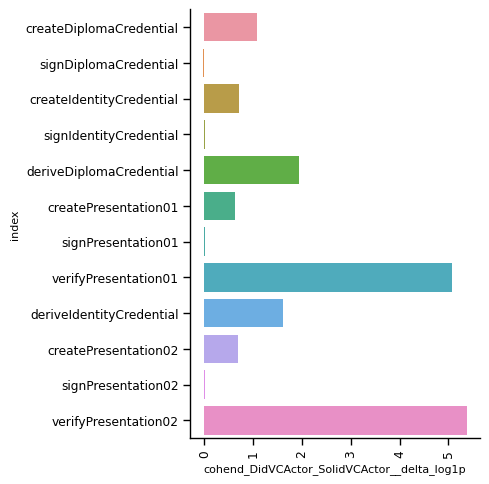

In [42]:
g= sns.catplot(df_effect_sizes.reset_index(),y='index',x=colname_effect_size, kind='bar',orient='h')
g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation=90)
plt.show()

---
### [WIP] Analyze effects of document loader cache option configurations

In [68]:
def plot_stepname_histograms_per_dlco_group(df: pd.DataFrame, selected_stepName: str):
    # Create grouper based on different document loader cache configurations
    GROUP_COLUMNS_DLCO = df[['dlco']].columns.to_list()
    grpr_dlco = df.groupby(GROUP_COLUMNS_DLCO)
    snsdata = pd.concat({ f'G{i}': grpr_dlco.get_group(k) for i,k in enumerate(grpr_dlco.groups.keys()) }).report.reset_index().rename({'level_0':'dlco_group'}, axis=1)
    snsdata = snsdata[snsdata.stepName == selected_stepName]
    df_dlco_group_table = pd.concat({ f'G{i}': grpr_dlco.get_group(k) for i,k in enumerate(grpr_dlco.groups.keys()) }).reset_index().rename({'level_0':'dlco_group'}, axis=1)[['dlco_group','dlco']].drop_duplicates().droplevel(0, axis=1).dropna(how='all',axis=1).rename({'':'DLCO_GROUP'},axis=1).set_index('DLCO_GROUP').T
    df_dlco_group_table_marks = df_dlco_group_table.replace({True: '√', False: 'x'})

    g = sns.FacetGrid(snsdata,row = 'dlco_group',aspect=4,sharex=True, sharey=True, hue='className')
    g.map_dataframe(sns.histplot,x='delta_log1p', stat='percent')
    g.add_legend()

    for g_k, ax_k in g.axes_dict.items():
        g_size = snsdata.groupby('dlco_group').size()[g_k]
        title_center = ax_k.get_title()
        ax_k.set_title(f'{g_k}\n',loc='left')
        ax_k.set_title("\n".join(map(lambda x: '{}: {}'.format(*x), df_dlco_group_table_marks[g_k].to_dict().items())),loc='center', )
        title_right = f'{selected_stepName}\nN: {g_size}'
        ax_k.set_title(title_right,loc='right', fontdict = {'fontsize': 8})

    g.tight_layout()
    
    return g

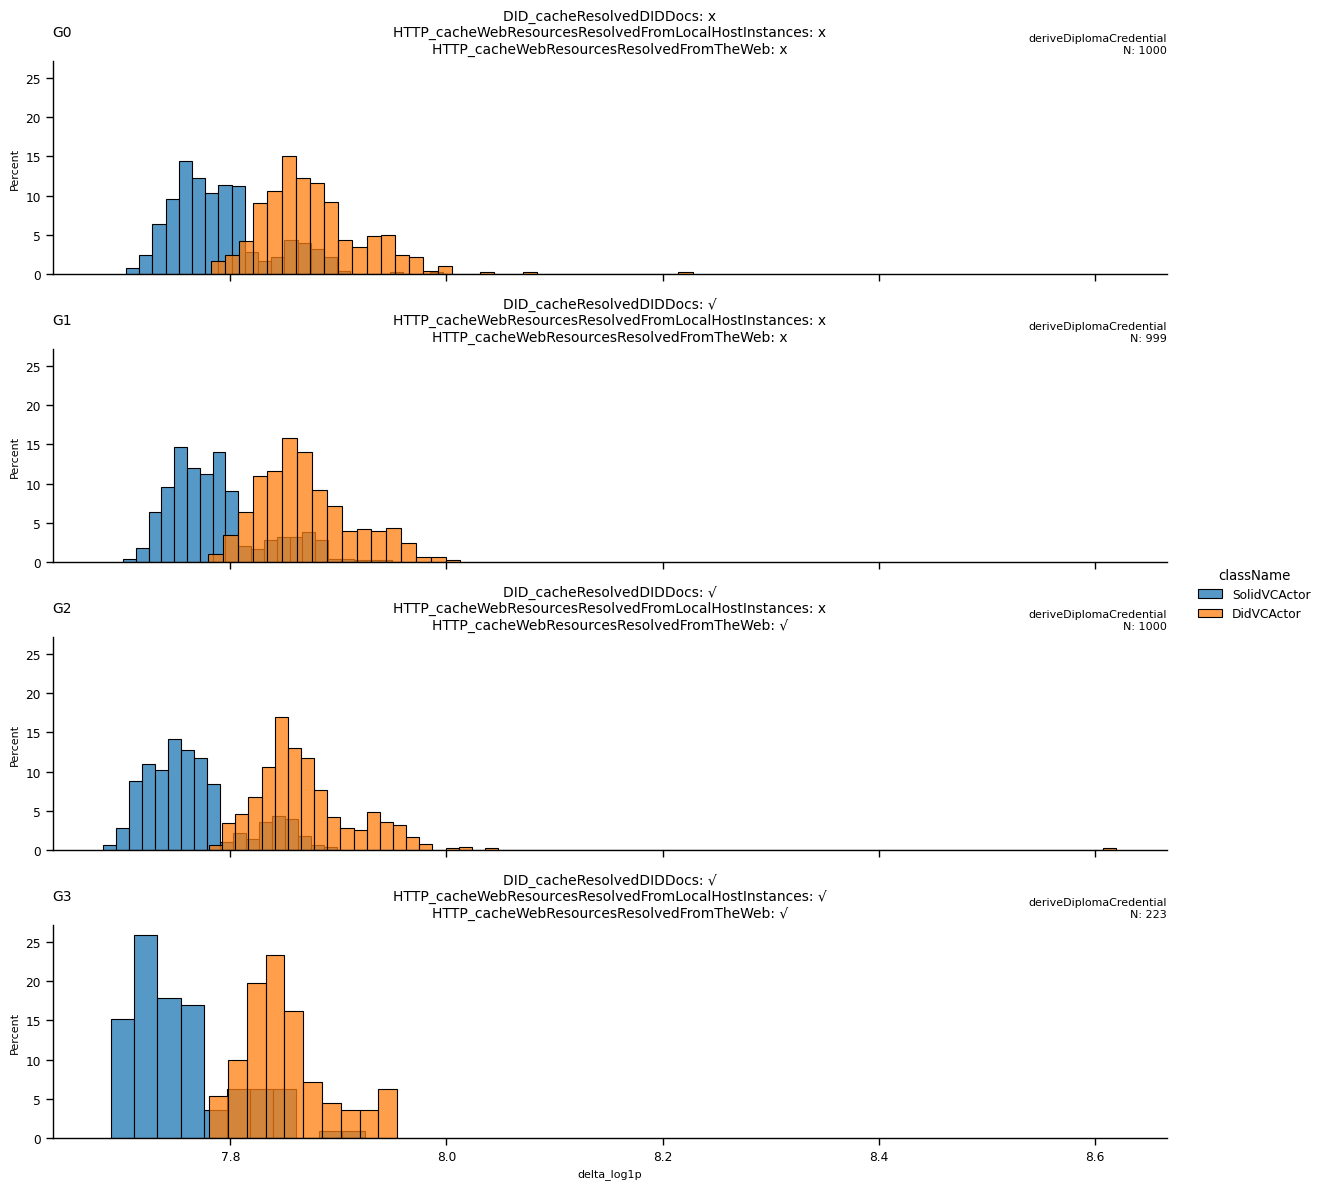

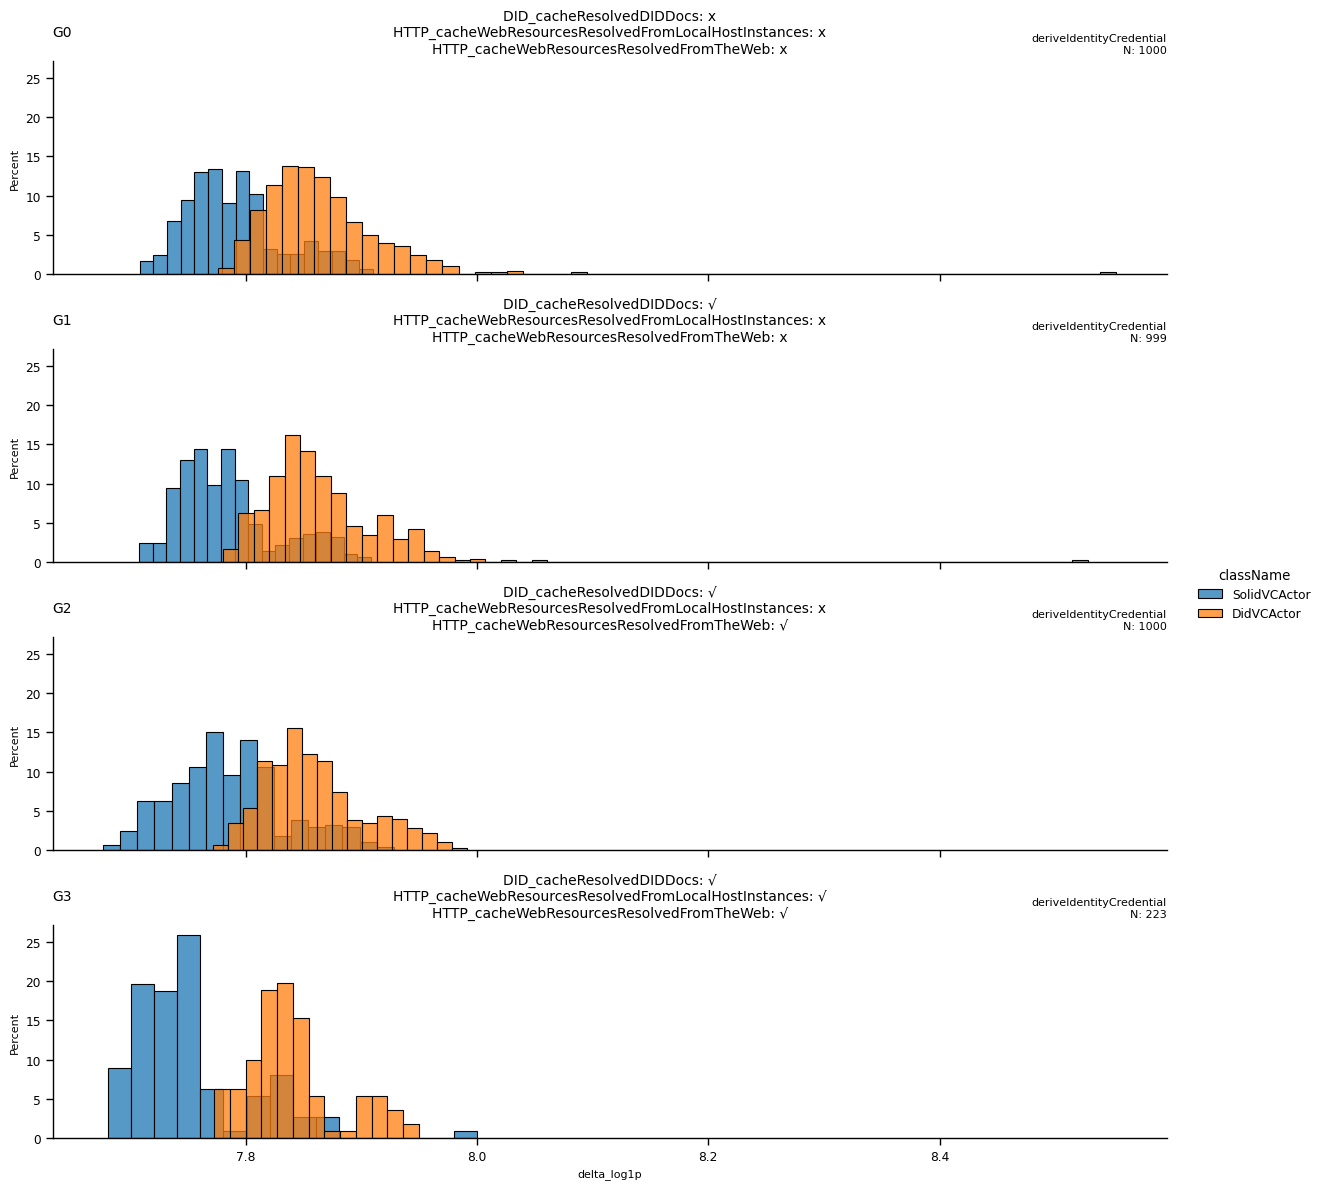

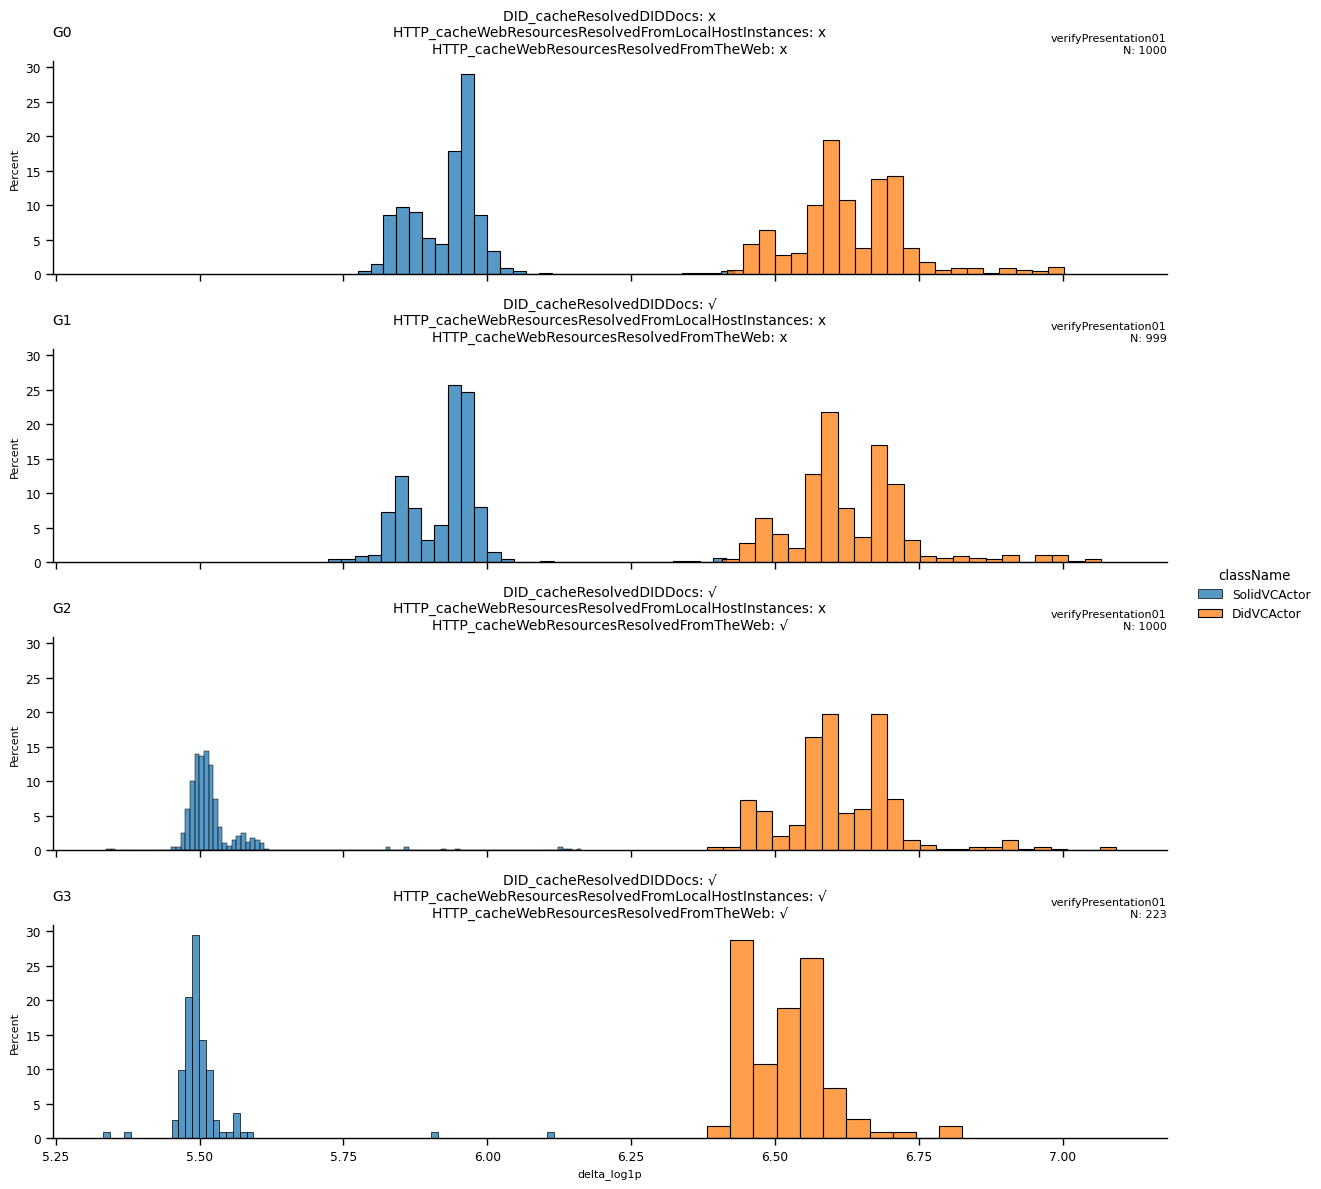

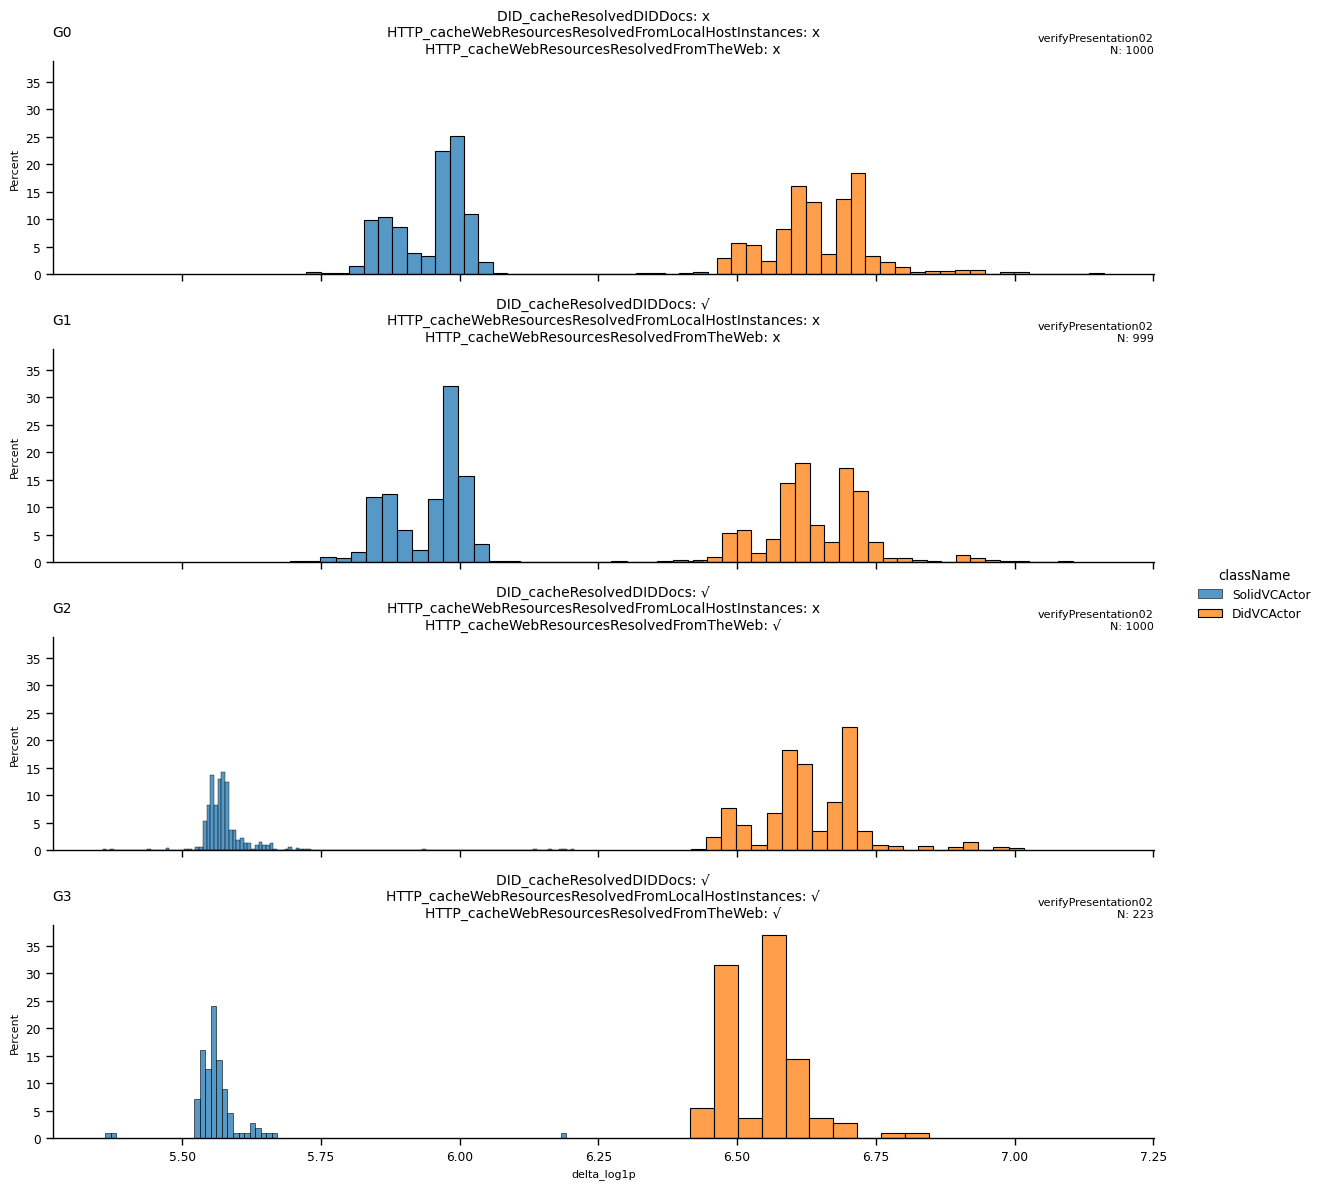

In [74]:
for sn in [ 'deriveDiplomaCredential', 'deriveIdentityCredential', 'verifyPresentation01', 'verifyPresentation02']:    
    g = plot_stepname_histograms_per_dlco_group(df_tl, sn)
    g.savefig(os.path.join(DIR_REPORT, f'histograms-per-dlco-group_{sn}.png'))